In [28]:
from utils import balance_sample

import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier

from scipy.stats import wilcoxon, mannwhitneyu

# Load Data

In [87]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']

# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [88]:
df = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df = df.append(df_)
    
df.to_csv('all_markers.csv')

In [89]:
df_markers = (df
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
              .query("preproc == 'subtracted'")
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events', 'preproc', 'epoch_type'], axis = 1)
              .query("mind in ['on-task','dMW', 'sMW']")
             )

markers = ['wSMI', 'p_e', 'k', 'b', 'b_n', 'g', 'g_n', 't', 't_n',
       'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b']

# By Subject Univariate analyses 

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [68]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .groupby(['mind2', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_mind.drop(markers, axis=1).columns})

df_mind = (df_mind
    .groupby(['mind2', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
)
df_mind = balance_sample(df_mind, 'participant', 'mind2', levels = 2).drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also


AUC wSMI = 0.46153846153846156 WilcoxonResult(statistic=44.0, pvalue=0.946044921875)
AUC p_e = 0.5207100591715976 WilcoxonResult(statistic=42.0, pvalue=0.83935546875)
AUC k = 0.5029585798816568 WilcoxonResult(statistic=39.0, pvalue=0.684814453125)
AUC b = 0.47928994082840237 WilcoxonResult(statistic=35.0, pvalue=0.497314453125)
AUC b_n = 0.514792899408284 WilcoxonResult(statistic=35.0, pvalue=0.497314453125)
AUC g = 0.47337278106508873 WilcoxonResult(statistic=42.0, pvalue=0.83935546875)
AUC g_n = 0.4970414201183432 WilcoxonResult(statistic=45.0, pvalue=1.0)
AUC t = 0.5029585798816567 WilcoxonResult(statistic=43.0, pvalue=0.892578125)
AUC t_n = 0.5917159763313609 WilcoxonResult(statistic=22.0, pvalue=0.10986328125)
AUC d = 0.4792899408284023 WilcoxonResult(statistic=28.0, pvalue=0.243896484375)
AUC d_n = 0.4674556213017751 WilcoxonResult(statistic=35.0, pvalue=0.497314453125)
AUC a_n = 0.47928994082840237 WilcoxonResult(statistic=24.0, pvalue=0.146484375)
AUC a = 0.4378698224852071 Wil

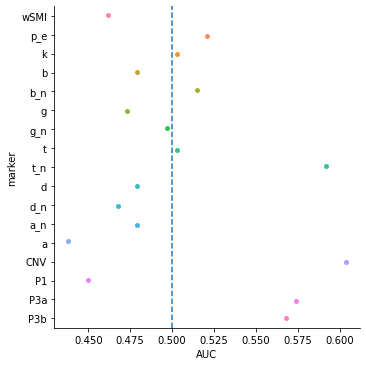

In [69]:
AUC = []
for i in markers:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = ot, y = mw)}')
    AUC.append([i, auc])
    
subject_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = subject_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.5661797752808988
AUC p_e = 0.5581460674157304
AUC k = 0.4173033707865168
AUC b = 0.56
AUC b_n = 0.5735955056179776
AUC g = 0.5921348314606742
AUC g_n = 0.5610112359550562
AUC t = 0.37449438202247187
AUC t_n = 0.38938202247191006
AUC d = 0.5703370786516854
AUC d_n = 0.581067415730337
AUC a_n = 0.6038202247191011
AUC a = 0.42573033707865165
AUC CNV = 0.39651685393258423
AUC P1 = 0.5875280898876405
AUC P3a = 0.38752808988764037
AUC P3b = 0.37174157303370786
Index(['on-task', 'mw'], dtype='object')


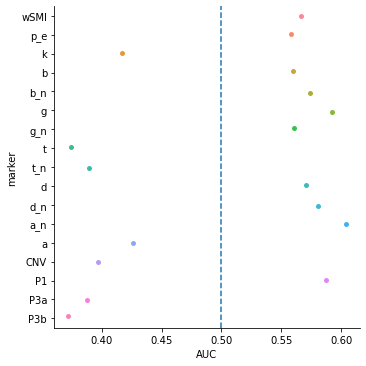

In [16]:
AUC = []
for i in markers:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [90]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['mind', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_mw.drop(markers, axis=1).columns})

df_mw = (df_mw
    .groupby(['mind', 'participant'], as_index = False).agg(agg_dict)
)
df_mw = balance_sample(df_mw, 'participant', 'mind', levels = 2).drop(['participant', 'probe','segment'], axis = 1) 


AUC wSMI = 0.5308641975308641 WilcoxonResult(statistic=76.0, pvalue=0.7018814086914062)
AUC p_e = 0.49999999999999994 WilcoxonResult(statistic=64.0, pvalue=0.3692169189453125)
AUC k = 0.5185185185185185 WilcoxonResult(statistic=84.0, pvalue=0.9661178588867188)
AUC b = 0.5123456790123457 WilcoxonResult(statistic=75.0, pvalue=0.6705245971679688)
AUC b_n = 0.5185185185185186 WilcoxonResult(statistic=57.0, pvalue=0.22875213623046875)
AUC g = 0.5030864197530864 WilcoxonResult(statistic=84.0, pvalue=0.9661178588867188)
AUC g_n = 0.5 WilcoxonResult(statistic=82.0, pvalue=0.8985748291015625)
AUC t = 0.4876543209876544 WilcoxonResult(statistic=85.0, pvalue=1.0)
AUC t_n = 0.49074074074074076 WilcoxonResult(statistic=85.0, pvalue=1.0)
AUC d = 0.49074074074074076 WilcoxonResult(statistic=80.0, pvalue=0.83172607421875)
AUC d_n = 0.49382716049382713 WilcoxonResult(statistic=79.0, pvalue=0.7987060546875)
AUC a_n = 0.5030864197530864 WilcoxonResult(statistic=76.0, pvalue=0.7018814086914062)
AUC a = 0.

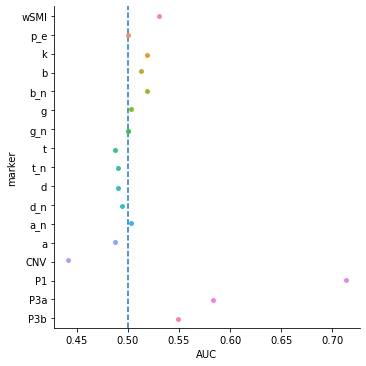

In [91]:
AUC = []
for i in markers:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = smw, y = dmw)}')
    AUC.append([i, auc])
subject_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = subject_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.5655056179775282
AUC p_e = 0.5561797752808989
AUC k = 0.5885393258426966
AUC b = 0.44000000000000006
AUC b_n = 0.5735955056179776
AUC g = 0.5920786516853932
AUC g_n = 0.5585393258426967
AUC t = 0.37449438202247187
AUC t_n = 0.3885393258426966
AUC d = 0.5684831460674157
AUC d_n = 0.5796629213483147
AUC a_n = 0.6040449438202248
AUC a = 0.5739325842696629
AUC CNV = 0.396629213483146
AUC P1 = 0.5875280898876405
AUC P3a = 0.6119101123595506
AUC P3b = 0.3712921348314607
Index(['on-task', 'mw'], dtype='object')


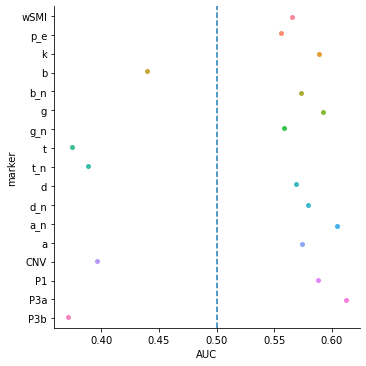

In [21]:
AUC = []
for i in markers:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# By Segment Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [54]:
agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also
)

In [55]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = []
for i in markers:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
segment_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = subject_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.5323595505617977 MannwhitneyuResult(statistic=4162.0, pvalue=0.22187598409133724)
AUC p_e = 0.498876404494382 MannwhitneyuResult(statistic=4440.0, pvalue=0.4899050043756043)
AUC k = 0.46207865168539325 MannwhitneyuResult(statistic=4112.5, pvalue=0.1846628997384837)
AUC b = 0.45067415730337085 MannwhitneyuResult(statistic=4011.0, pvalue=0.12137866284703919)
AUC b_n = 0.4448314606741573 MannwhitneyuResult(statistic=3959.0, pvalue=0.0956665405491543)
AUC g = 0.4544943820224719 MannwhitneyuResult(statistic=4045.0, pvalue=0.14061736062183222)
AUC g_n = 0.4807865168539326 MannwhitneyuResult(statistic=4279.0, pvalue=0.32484391951249214)
AUC t = 0.510561797752809 MannwhitneyuResult(statistic=4356.0, pvalue=0.4016513190616169)
AUC t_n = 0.5970786516853932 MannwhitneyuResult(statistic=3586.0, pvalue=0.010716112377762172)
AUC d = 0.4762921348314606 MannwhitneyuResult(statistic=4239.0, pvalue=0.28748326762595944)
AUC d_n = 0.5082022471910113 MannwhitneyuResult(statistic=4377.0, pvalue

NameError: name 'subject_mind_roc' is not defined

AUC wSMI = 0.5673033707865168
AUC p_e = 0.5562359550561797
AUC k = 0.5824719101123594
AUC b = 0.5368539325842697
AUC b_n = 0.4264606741573034
AUC g = 0.5921348314606742
AUC g_n = 0.5587640449438203
AUC t = 0.3750561797752809
AUC t_n = 0.3889887640449438
AUC d = 0.5668539325842696
AUC d_n = 0.5801685393258427
AUC a_n = 0.3949438202247191
AUC a = 0.573370786516854
AUC CNV = 0.6033707865168539
AUC P1 = 0.5875280898876405
AUC P3a = 0.6124719101123595
AUC P3b = 0.371123595505618
Index(['on-task', 'mw'], dtype='object')


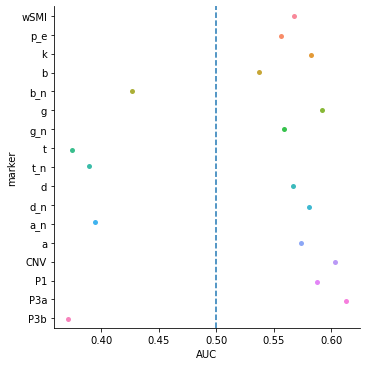

In [24]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = []
for i in markers:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.4375474983206172
AUC p_e = 0.4896168492670631
AUC k = 0.5024335623575753
AUC b = 0.5029635164990517
AUC b_n = 0.5251507546542695
AUC g = 0.5233673862063019
AUC g_n = 0.4863379572140722
AUC t = 0.5839878474926946
AUC t_n = 0.5861534720306618
AUC d = 0.4875855261269176
AUC d_n = 0.5031184637067466
AUC a_n = 0.5237620762206309
AUC a = 0.5063928077092706
AUC CNV = 0.5450558078253287
AUC P1 = 0.5278271530066373
AUC P3a = 0.5638230643677872
AUC P3b = 0.596444566740103


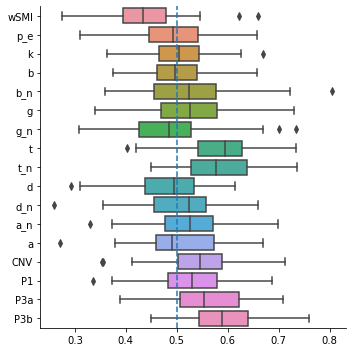

In [25]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = pd.DataFrame()
for i in markers:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
markers = df_mind.drop('mind2', axis = 1).columns

n_estimators = 2000
AUC = pd.DataFrame()
for i in markers:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

In [ ]:
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [92]:
agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
    .drop(['participant', 'probe', 'segment'], axis = 1)
)

AUC wSMI = 0.49995934959349586 MannwhitneyuResult(statistic=49196.0, pvalue=0.49938518325214426)
AUC p_e = 0.39553861788617894 MannwhitneyuResult(statistic=38921.0, pvalue=3.008056830837823e-06)
AUC k = 0.4770020325203252 MannwhitneyuResult(statistic=46937.0, pvalue=0.15957090566703258)
AUC b = 0.432530487804878 MannwhitneyuResult(statistic=42561.0, pvalue=0.001733049315276102)
AUC b_n = 0.46834349593495933 MannwhitneyuResult(statistic=46085.0, pvalue=0.08512911305704751)
AUC g = 0.46724593495934963 MannwhitneyuResult(statistic=45977.0, pvalue=0.07795985246493864)
AUC g_n = 0.4945934959349594 MannwhitneyuResult(statistic=48668.0, pvalue=0.4074809515641047)
AUC t = 0.49149390243902435 MannwhitneyuResult(statistic=48363.0, pvalue=0.35631466672452)
AUC t_n = 0.5183130081300813 MannwhitneyuResult(statistic=47398.0, pvalue=0.21382038027732347)
AUC d = 0.5352439024390244 MannwhitneyuResult(statistic=45732.0, pvalue=0.06340447093200176)
AUC d_n = 0.603130081300813 MannwhitneyuResult(statistic

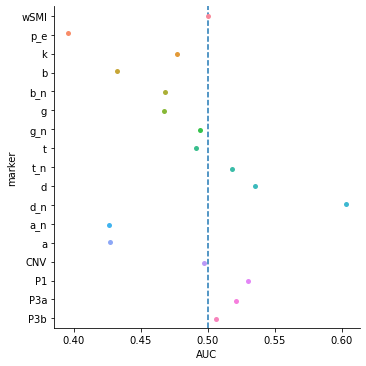

In [93]:
markers = df_mw.drop('mind', axis = 1).columns

AUC = []
for i in markers:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
segment_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = segment_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.4811782608995791
AUC p_e = 0.5699905399448791
AUC k = 0.5341743359332517
AUC b = 0.5926045497973648
AUC b_n = 0.521120386134637
AUC g = 0.5708195165669535
AUC g_n = 0.5291655374610504
AUC t = 0.524925636084173
AUC t_n = 0.49573784101902235
AUC d = 0.5024536293591203
AUC d_n = 0.5640876173846011
AUC a_n = 0.5538035315268864
AUC a = 0.5619106376300894
AUC CNV = 0.5203723751569408
AUC P1 = 0.5247069705004989
AUC P3a = 0.4983396918201629
AUC P3b = 0.538724141718267


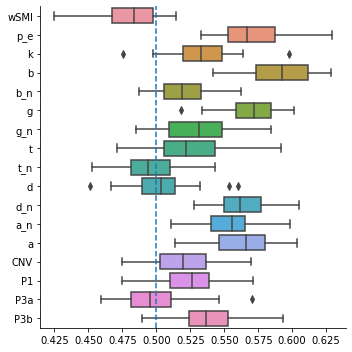

In [101]:
markers = df_mw.drop('mind', axis = 1).columns

AUC = pd.DataFrame()
for i in markers:
    
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# By Trial Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [94]:
agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also
)

AUC wSMI = 0.49995934959349586 MannwhitneyuResult(statistic=49196.0, pvalue=0.49938518325214426)
AUC p_e = 0.39553861788617894 MannwhitneyuResult(statistic=38921.0, pvalue=3.008056830837823e-06)
AUC k = 0.4770020325203252 MannwhitneyuResult(statistic=46937.0, pvalue=0.15957090566703258)
AUC b = 0.432530487804878 MannwhitneyuResult(statistic=42561.0, pvalue=0.001733049315276102)
AUC b_n = 0.46834349593495933 MannwhitneyuResult(statistic=46085.0, pvalue=0.08512911305704751)
AUC g = 0.46724593495934963 MannwhitneyuResult(statistic=45977.0, pvalue=0.07795985246493864)
AUC g_n = 0.4945934959349594 MannwhitneyuResult(statistic=48668.0, pvalue=0.4074809515641047)
AUC t = 0.49149390243902435 MannwhitneyuResult(statistic=48363.0, pvalue=0.35631466672452)
AUC t_n = 0.5183130081300813 MannwhitneyuResult(statistic=47398.0, pvalue=0.21382038027732347)
AUC d = 0.5352439024390244 MannwhitneyuResult(statistic=45732.0, pvalue=0.06340447093200176)
AUC d_n = 0.603130081300813 MannwhitneyuResult(statistic

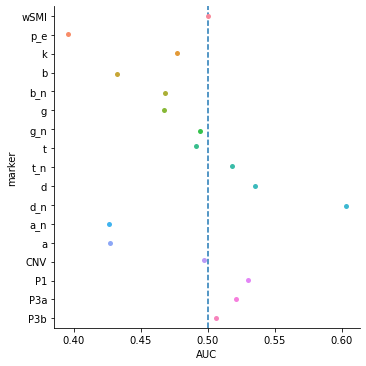

In [95]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = []
for i in markers:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
trial_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = trial_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.5346286188411574
AUC p_e = 0.5114249225187704
AUC k = 0.5494659692678125
AUC b = 0.4607387764066606
AUC b_n = 0.5455736051345041
AUC g = 0.44149658757209215
AUC g_n = 0.5102616872605403
AUC t = 0.5353891957407694
AUC t_n = 0.5543507439011494
AUC d = 0.49245117258994736
AUC d_n = 0.512177364906087
AUC a_n = 0.5473347270464399
AUC a = 0.44281844582008084
AUC CNV = 0.4860981184873061
AUC P1 = 0.4946962979834544
AUC P3a = 0.5176396899123913
AUC P3b = 0.5529922803478318
Index(['on-task', 'mw'], dtype='object')


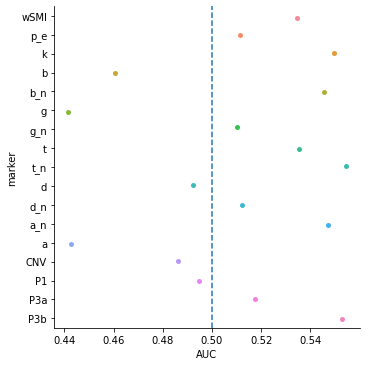

In [46]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = []
for i in markers:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.47255057470999295
AUC p_e = 0.4895388609747214
AUC k = 0.5062515622346035
AUC b = 0.5038216883998508
AUC b_n = 0.5249098900988609
AUC g = 0.5253790038523128
AUC g_n = 0.4939455921043854
AUC t = 0.6023211894290261
AUC t_n = 0.5852325143194103
AUC d = 0.5021670702249412
AUC d_n = 0.4592014866397875
AUC a_n = 0.5209284703302843
AUC a = 0.5018993135806484
AUC CNV = 0.42822317543432875
AUC P1 = 0.5473373513633032
AUC P3a = 0.4432398293390024
AUC P3b = 0.5211749238928197


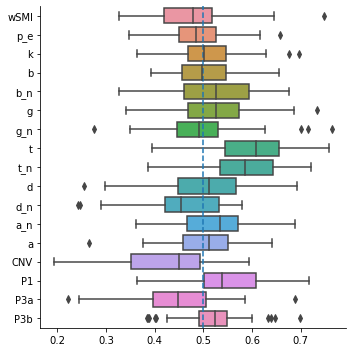

In [52]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = pd.DataFrame()
for i in markers:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [53]:
markers = df_mind.drop('mind2', axis = 1).columns

n_estimators = 2000
AUC = pd.DataFrame()
for i in markers:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

AUC wSMI = 0.5160715504292532
AUC p_e = 0.4681811577543366
AUC k = 0.5667457357113245
AUC b = 0.5648814943354399
AUC b_n = 0.5198306052596219
AUC g = 0.5161053217458488
AUC g_n = 0.4465213080597508
AUC t = 0.5946024604134179
AUC t_n = 0.6383682294620958
AUC d = 0.4720943442001896
AUC d_n = 0.4964001586768471
AUC a_n = 0.5128533666642188
AUC a = 0.4972004840221784
AUC CNV = 0.5165855498101354
AUC P1 = 0.5074655864802583
AUC P3a = 0.5230983008336334
AUC P3b = 0.5510666876253385


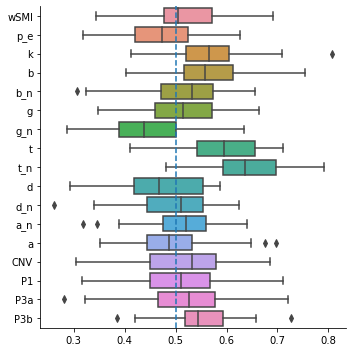

In [54]:
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [98]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe', 'segment'], axis = 1)
)

AUC wSMI = 0.49461944646758926
AUC p_e = 0.42323834668608884
AUC k = 0.4937694727684713
AUC b = 0.44389313749291903
AUC b_n = 0.48203953224892776
AUC g = 0.47425345957756737
AUC g_n = 0.5103357408756171
AUC t = 0.4763256656146314
AUC t_n = 0.5046446346200535
AUC d = 0.5182153839928786
AUC d_n = 0.5668816257991421
AUC a_n = 0.4384336813142348
AUC a = 0.43282198349113865
AUC CNV = 0.5008911952739339
AUC P1 = 0.5198389576758112
AUC P3a = 0.5150916484583636
AUC P3b = 0.5179038196973376


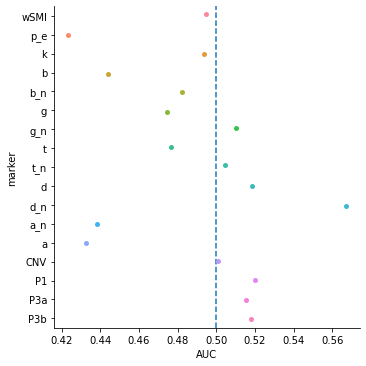

In [99]:
markers = df_mw.drop('mind', axis = 1).columns

AUC = []
for i in markers:
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])
trial_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = trial_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.5143342660580114
AUC p_e = 0.5785466072763985
AUC k = 0.5391837358480911
AUC b = 0.6046043693914409
AUC b_n = 0.5318217858023713
AUC g = 0.5548606716478324
AUC g_n = 0.5546905795405731
AUC t = 0.5341408527832584
AUC t_n = 0.5182317507856701
AUC d = 0.4911585068841249
AUC d_n = 0.5534022658043775
AUC a_n = 0.5674706896241056
AUC a = 0.5871223412772264
AUC CNV = 0.5317990013227547
AUC P1 = 0.5051494898105324
AUC P3a = 0.5322790302695809
AUC P3b = 0.5183271682774749


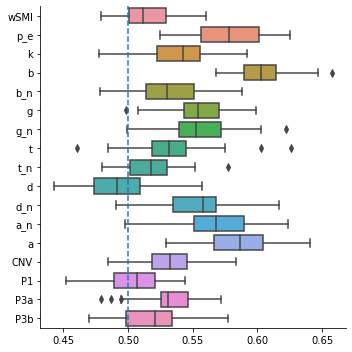

In [223]:
markers = df_mw.drop('mind', axis = 1).columns

AUC = pd.DataFrame()
for i in markers:
    
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# Plots

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

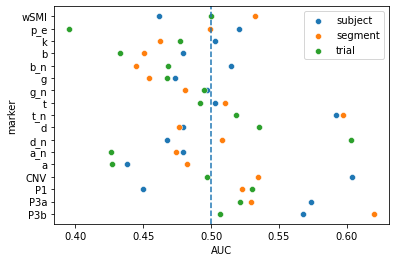

In [76]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mind_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

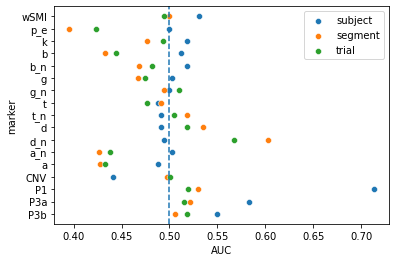

In [100]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mw_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()